In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline


class_label =  os.listdir(f'hw5_data/train/')

In [2]:
def DataLoader(path, standardize=False):
    img_list = []
    label_list = []
    num_img = 0
    for classes in class_label:
        for img in os.listdir(f'hw5_data/{path}/{classes}'):
            if img.endswith('.jpg'):
                label_list.append(classes)
                original = cv2.imread(f'hw5_data/{path}/{classes}/{img}', cv2.IMREAD_GRAYSCALE).astype('uint8')
                
                if standardize:
                    mean = np.mean(original)
                    stds = np.std(original)
                    original = (original-mean) / (stds+1e-6)
                    


                img_list.append(original)
                num_img += 1

    return np.array(img_list), label_list, num_img

train_img, train_label, num_train = DataLoader('train', standardize=False)
test_img, test_label, num_test = DataLoader('test', standardize=False)

In [3]:
import cyvlfeat as vlfeat

for i in range(num_train):
    location, sift_feature = vlfeat.sift.dsift(train_img[i], fast=False, step=11)
    
    if i == 0:
        des = sift_feature # (1,128)
    else:
        des = np.vstack((des, sift_feature)).astype('float')  

dim = 300
center = vlfeat.kmeans.kmeans(des, dim) # (dim,128)

In [4]:
def BoS(img, center):
    step = 11
    feature = np.zeros((len(img), center.shape[0]))
    for i in range(len(img)):
        location, sift_feature = vlfeat.sift.dsift(img[i] ,fast = True, step = step)
        sift_feature = sift_feature.astype(np.float64)
        assignments = vlfeat.kmeans.kmeans_quantize(sift_feature, center)
        u, counts = np.unique(assignments, return_counts=True)
        counts = counts.astype(np.float64)
        feature[i, u] = counts/np.sum(counts)
    
    return feature

In [5]:
train_feature = BoS(train_img, center)
test_feature = BoS(test_img, center)

In [6]:
def get_dst(train_feature, test_feature):


    
    D = np.zeros([num_train,num_test])
    
    for i in range(num_train):
        for j in range(num_test):
            D[i,j] = np.sum(np.abs(train_feature[i] - test_feature[j]))
    return D

distance = get_dst(train_feature, test_feature) # (1500,150)

In [7]:
def create_dict():
    dic = {}
    for name in set(train_label):
        dic[name] = 0
    return dic

def KNN(k):
    
    acc = 0

    for i in range(num_test):
        dic = create_dict()
        idx = np.argsort(distance[:,i])[:k]
    
        for j in idx:
            dic[train_label[j]] += 1
            #print(train_label[j])

        if max(dic, key=dic.get) == test_label[i]:
            acc += 1


    return acc / num_test

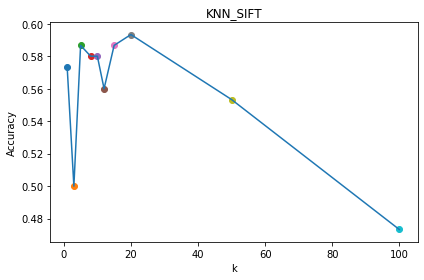

In [9]:
score = []
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]
for i in k_choices:
    acc = KNN(i)
    plt.scatter(i, acc)
    score.append(acc)
    
  

    
plt.plot(k_choices, score)
plt.title('KNN_SIFT')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.tight_layout()